## Encoders

#### Transformer-based Encoding with Attention Mechanisms
The transformers self attention mechanisms should do well with capturing temporal dependencies. Its positional encoding should also allow models to generalize across different temporal scales, which is likely to be necessary if we want models to do well across subjects.

If we see good results, there are some avenues for interpretability:
- Visualize attention weights to see which parts of the spike train the model focuses on for each output 
- See if attention patterns change for different subjects 
- Look at learned positional encodings to see how model represents temporal info 


#### Variational Autoencoder (VAE) with Disentangled Latent Space
The VAE compresses the continuous representation of spike trains and could capture any patterns that might exist across subjects. If you use a higher β value in the loss function, it allows for disengtanglement. This can allow for better interpretability if each dimension in the latent space corresponds to specific aspects of neural activity.

Some avenues for interpretation:
- Look at decoder weights to see how each latent dimension influences the reconstruction 
- Perform correlation analysis between latent dimensions and original features 
- Change latent dimensions and look at effect on decoded output 

*I haven't gotten the VAE to work well on the spike trains yet, should be possible though...*


#### Relevant sources

##### Transformer
- https://arxiv.org/pdf/2206.06131

An architecture that allows for permutation invariance, "provides
impressive performance in transfer across recordings of different animals without
any neuron-level correspondence." 

- https://transformer-circuits.pub/2023/monosemantic-features/index.html#setup-autoencoder

I would like to explore a similar approach to understanding how the transformer is encoding the neural activity


##### VAE

- https://arxiv.org/pdf/2310.17325
More on casually disentagnled learning representations, do a good job of explaining it and also open-sources their code.

- https://encord.com/blog/diffusion-models-with-transformers/
In a Variational Autoencoder (VAE), the latent space is a lower-dimensional space into which the input data is encoded. This encoding process is a form of dimensionality reduction, where high-dimensional input data is compressed into a lower-dimensional representation. The latent space captures the essential characteristics of the data, and it is from this space that new samples are generated during the decoding process.

The quality of the VAE’s output is largely dependent on how well the latent space captures the underlying structure of the input data. If the latent space is too small or not well-structured, the VAE may not be able to generate high-quality samples. If the latent space is well-structured and of appropriate size, the VAE can generate high-quality samples that accurately reflect the characteristics of the input data.



## Train VAE and Transformer encoders 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load and prepare data 
file_path = 'output/spike_trains_with_stimulus_session_715093703_1.pkl'
with open(file_path, 'rb') as f:
    spike_trains = pickle.load(f)

if 'frame' in spike_trains.columns:
    spike_trains = spike_trains.drop('frame', axis=1)

spike_train_array = spike_trains.values
scaler = MinMaxScaler()
spike_train_array_normalized = scaler.fit_transform(spike_train_array)
spike_train_tensor = torch.FloatTensor(spike_train_array_normalized)

batch_size = 32
dataset = TensorDataset(spike_train_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

input_dim = spike_train_array.shape[1]
sequence_length = spike_train_array.shape[0]

print(f"Data loaded. Input dimension: {input_dim}, Sequence length: {sequence_length}")
print(f"Number of batches in train_loader: {len(train_loader)}")

# VAE setup 
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

#Transformer setup
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.output_layer = nn.Linear(d_model, input_dim)
        
    def forward(self, src):
        src = self.embedding(src)
        src = src.unsqueeze(1) 
        src = self.pos_encoder(src.transpose(0, 1)).transpose(0, 1)
        output = self.transformer_encoder(src)
        return self.output_layer(output.squeeze(1))

# Initialize models
latent_dim = 32
hidden_dim = 256
vae = VAE(input_dim, latent_dim, hidden_dim)

d_model = 256
nhead = 8
num_layers = 3
dim_feedforward = 512
transformer = TransformerEncoder(input_dim, d_model, nhead, num_layers, dim_feedforward)

# Loss functions, optimizers
def vae_loss(recon_x, x, mu, log_var):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + KLD

vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)
transformer_optimizer = optim.Adam(transformer.parameters(), lr=1e-3)
transformer_criterion = nn.MSELoss()

# Training functions
def train_vae(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data,) in enumerate(train_loader):
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(data)
            loss = vae_loss(recon_batch, data, mu, log_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'VAE Epoch: {epoch}, Average loss: {total_loss / len(train_loader.dataset):.4f}')

def train_transformer(model, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data,) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Transformer Epoch: {epoch}, Average loss: {total_loss / len(train_loader.dataset):.4f}')

# Train models
print("Training VAE...")
train_vae(vae, train_loader, vae_optimizer, epochs=10)

print("\nTraining Transformer...")
train_transformer(transformer, train_loader, transformer_optimizer, transformer_criterion, epochs=10)

# Function to encode spike trains
def encode_spike_trains(model, spike_trains):
    model.eval()
    with torch.no_grad():
        if isinstance(model, VAE):
            mu, _ = model.encode(spike_trains)
            return mu
        elif isinstance(model, TransformerEncoder):
            return model(spike_trains)

# Encode spike trains using both models
vae_encodings = encode_spike_trains(vae, spike_train_tensor)
transformer_encodings = encode_spike_trains(transformer, spike_train_tensor)

print(f"\nVAE encodings shape: {vae_encodings.shape}")
print(f"Transformer encodings shape: {transformer_encodings.shape}")

# Save encodings
torch.save(vae_encodings, 'vae_encodings.pt')
torch.save(transformer_encodings, 'transformer_encodings.pt')

print("\nEncodings saved. You can now use these for downstream tasks.")

Data loaded. Input dimension: 2073, Sequence length: 5950
Number of batches in train_loader: 186
Training VAE...
VAE Epoch: 0, Average loss: 32.5337
VAE Epoch: 1, Average loss: 28.9127
VAE Epoch: 2, Average loss: 28.0870
VAE Epoch: 3, Average loss: 27.7206
VAE Epoch: 4, Average loss: 27.5137
VAE Epoch: 5, Average loss: 27.4074
VAE Epoch: 6, Average loss: 27.2938
VAE Epoch: 7, Average loss: 27.2962
VAE Epoch: 8, Average loss: 27.1935
VAE Epoch: 9, Average loss: 27.1396

Training Transformer...
Transformer Epoch: 0, Average loss: 0.0008
Transformer Epoch: 1, Average loss: 0.0004
Transformer Epoch: 2, Average loss: 0.0004
Transformer Epoch: 3, Average loss: 0.0004
Transformer Epoch: 4, Average loss: 0.0003
Transformer Epoch: 5, Average loss: 0.0003
Transformer Epoch: 6, Average loss: 0.0003
Transformer Epoch: 7, Average loss: 0.0003
Transformer Epoch: 8, Average loss: 0.0003
Transformer Epoch: 9, Average loss: 0.0003

VAE encodings shape: torch.Size([5950, 32])
Transformer encodings shape

## Run LSTM on encoded data
 Run twice if you get CUDA mismatch error

In [2]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the original spike train data for labels
spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_1.pkl'
with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)

# Load the encodings
vae_encodings = torch.load('vae_encodings.pt')
transformer_encodings = torch.load('transformer_encodings.pt')

# Prepare labels
y = spike_df['frame'].values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Function to prepare data for LSTM
def prepare_data_for_lstm(encodings, labels, seq_len=1):
    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(encodings, y_encoded, test_size=0.2, random_state=42, shuffle=False)
    
    # Reshape input to 3 dimensions (samples, timesteps, features)
    num_samples_train = X_train.shape[0] // seq_len
    num_samples_test = X_test.shape[0] // seq_len
    num_features = X_train.shape[1]
    
    X_train = X_train[:num_samples_train*seq_len].reshape(num_samples_train, seq_len, num_features)
    X_test = X_test[:num_samples_test*seq_len].reshape(num_samples_test, seq_len, num_features)
    
    # Reshape labels
    y_train = y_train[:num_samples_train*seq_len].reshape(num_samples_train, seq_len)
    y_test = y_test[:num_samples_test*seq_len].reshape(num_samples_test, seq_len)
    
    # Use only the last label for each sequence
    y_train = y_train[:, -1]
    y_test = y_test[:, -1]
    
    return X_train, X_test, y_train, y_test

# Prepare data for both VAE and Transformer encodings
X_train_vae, X_test_vae, y_train_vae, y_test_vae = prepare_data_for_lstm(vae_encodings, y_encoded)
X_train_transformer, X_test_transformer, y_train_transformer, y_test_transformer = prepare_data_for_lstm(transformer_encodings, y_encoded)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Training function
def train_lstm(X_train, y_train, X_test, y_test, model_name):
    # Model parameters
    input_dim = X_train.shape[2]
    hidden_dim = 128
    layer_dim = 1
    output_dim = len(np.unique(y_encoded))
    
    # Training parameters
    learning_rate = 0.001
    num_epochs = 15
    batch_size = 64

    # DataLoaders
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Evaluation
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        test_accuracy = 100 * test_correct / test_total

        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {train_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_accuracy:.2f}%, '
              f'Test Acc: {test_accuracy:.2f}%')

# Train LSTM on VAE encodings
print("Training LSTM on VAE encodings:")
train_lstm(X_train_vae, y_train_vae, X_test_vae, y_test_vae, "VAE-LSTM")

print("\nTraining LSTM on Transformer encodings:")
train_lstm(X_train_transformer, y_train_transformer, X_test_transformer, y_test_transformer, "Transformer-LSTM")

Training LSTM on VAE encodings:


/tmp/ipykernel_2312969/2880422318.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
/tmp/ipykernel_2312969/2880422318.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))


VAE-LSTM - Epoch [1/15], Loss: 4.7818, Train Acc: 0.82%, Test Acc: 0.42%
VAE-LSTM - Epoch [2/15], Loss: 4.7785, Train Acc: 0.78%, Test Acc: 0.42%
VAE-LSTM - Epoch [3/15], Loss: 4.7752, Train Acc: 1.07%, Test Acc: 0.67%
VAE-LSTM - Epoch [4/15], Loss: 4.7713, Train Acc: 0.99%, Test Acc: 0.92%
VAE-LSTM - Epoch [5/15], Loss: 4.7680, Train Acc: 0.92%, Test Acc: 0.92%
VAE-LSTM - Epoch [6/15], Loss: 4.7656, Train Acc: 1.01%, Test Acc: 0.84%
VAE-LSTM - Epoch [7/15], Loss: 4.7636, Train Acc: 1.05%, Test Acc: 0.92%
VAE-LSTM - Epoch [8/15], Loss: 4.7608, Train Acc: 1.24%, Test Acc: 0.76%
VAE-LSTM - Epoch [9/15], Loss: 4.7591, Train Acc: 1.13%, Test Acc: 0.76%
VAE-LSTM - Epoch [10/15], Loss: 4.7559, Train Acc: 1.26%, Test Acc: 0.42%
VAE-LSTM - Epoch [11/15], Loss: 4.7539, Train Acc: 1.34%, Test Acc: 0.34%
VAE-LSTM - Epoch [12/15], Loss: 4.7513, Train Acc: 1.45%, Test Acc: 0.67%
VAE-LSTM - Epoch [13/15], Loss: 4.7490, Train Acc: 1.41%, Test Acc: 0.25%
VAE-LSTM - Epoch [14/15], Loss: 4.7478, Train A

## Generate Visualizations

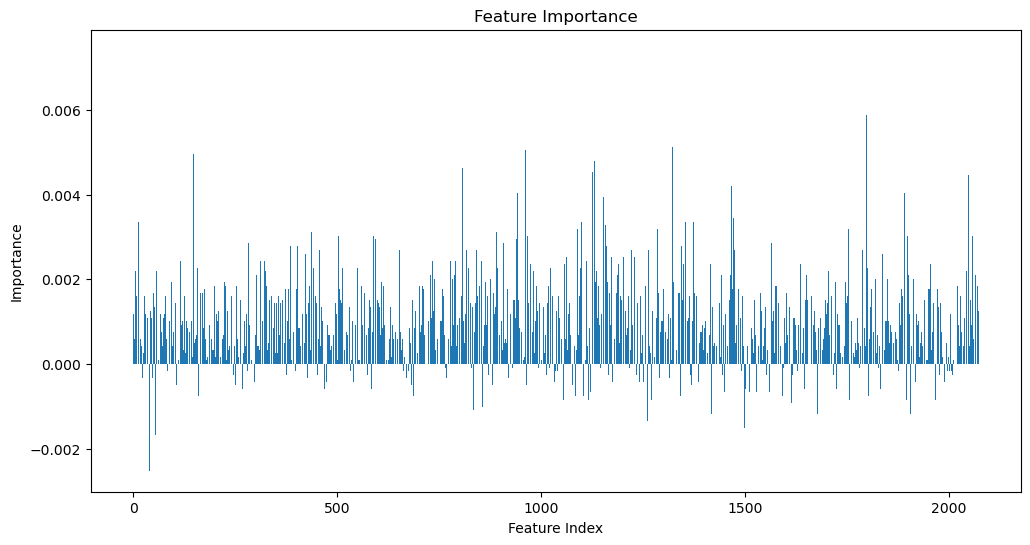

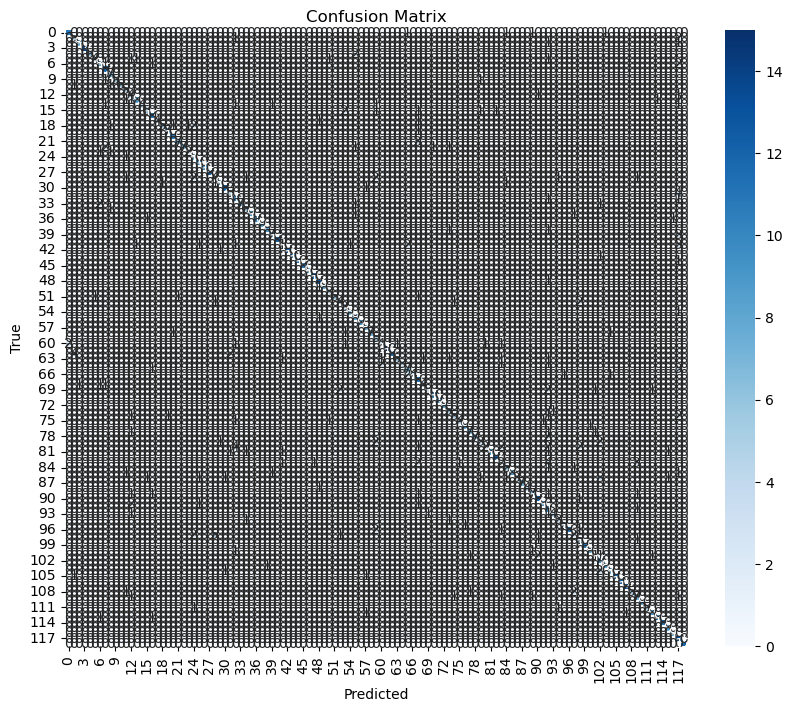

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff4c14f3130>
Traceback (most recent call last):
  File "/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Total samples: 1190
Misclassified samples: 286
Accuracy: 0.7597


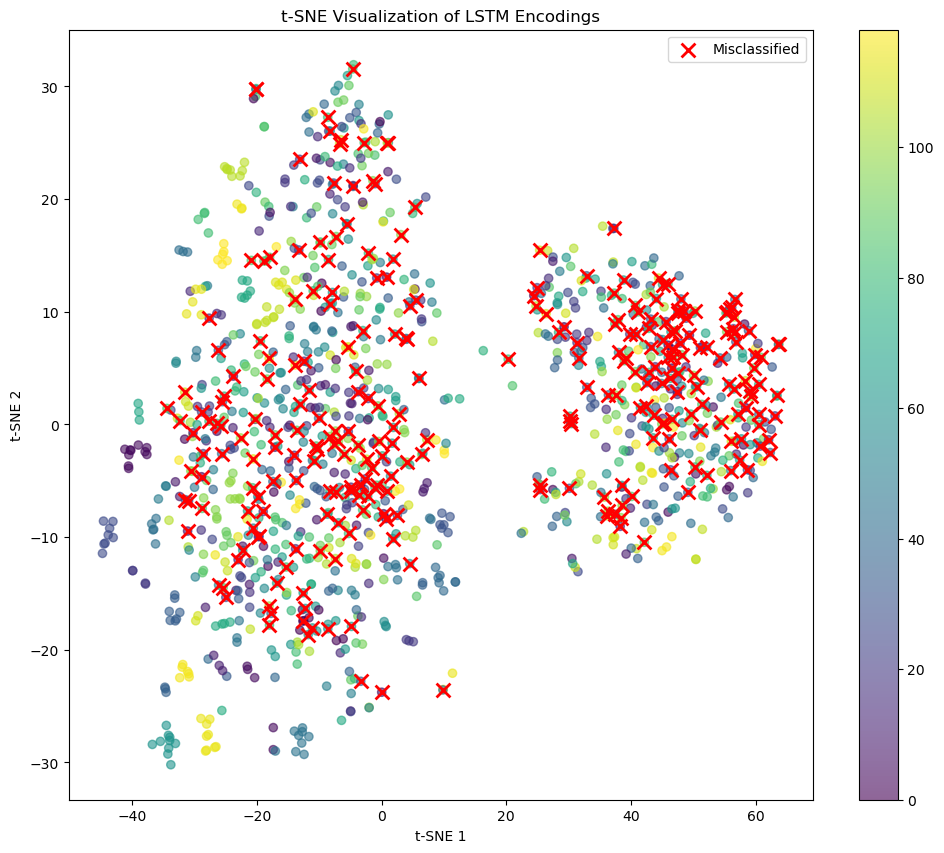

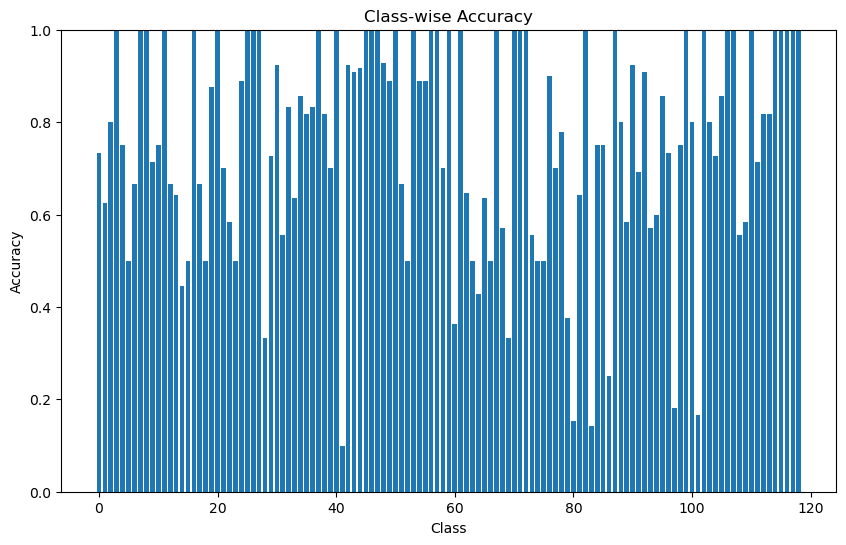

Visualization and interpretability analysis completed.


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load trained model, test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_dim=X_test_transformer.shape[2], hidden_dim=128, layer_dim=1, output_dim=len(np.unique(y_test_transformer)))
model.load_state_dict(torch.load('trained_transformer_lstm_model.pth', map_location=device))
model.to(device)
model.eval()

X_test_tensor = torch.FloatTensor(X_test_transformer).to(device)
y_test_tensor = torch.LongTensor(y_test_transformer).to(device)

# 1. Feature Importance Analysis
def compute_feature_importance(model, X_test, y_test, num_permutations=10):
    feature_importance = np.zeros(X_test.shape[2])
    baseline_accuracy = (model(X_test).argmax(dim=1) == y_test).float().mean().item()
    
    for feature in range(X_test.shape[2]):
        feature_accuracies = []
        for _ in range(num_permutations):
            X_permuted = X_test.clone()
            X_permuted[:, :, feature] = X_permuted[:, :, feature][torch.randperm(X_permuted.shape[0])]
            accuracy = (model(X_permuted).argmax(dim=1) == y_test).float().mean().item()
            feature_accuracies.append(accuracy)
        feature_importance[feature] = baseline_accuracy - np.mean(feature_accuracies)
    
    return feature_importance

feature_importance = compute_feature_importance(model, X_test_tensor, y_test_tensor)

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

# 2. Misclassification Analysis
def analyze_misclassifications(model, X_test, y_test):
    predictions = model(X_test).argmax(dim=1)
    misclassified = predictions != y_test
    
    cm = confusion_matrix(y_test.cpu(), predictions.cpu())
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print(f"Total samples: {len(y_test)}")
    print(f"Misclassified samples: {misclassified.sum().item()}")
    print(f"Accuracy: {1 - misclassified.float().mean().item():.4f}")
    
    return misclassified

misclassified = analyze_misclassifications(model, X_test_tensor, y_test_tensor)

# 3. Encoding Visualization using t-SNE
def visualize_encodings(X, y, misclassified, perplexity=30, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    X_tsne = tsne.fit_transform(X.cpu().numpy().reshape(X.shape[0], -1))
    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.cpu(), cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    
    # Highlight misclassified points
    plt.scatter(X_tsne[misclassified.cpu(), 0], X_tsne[misclassified.cpu(), 1], 
                c='red', marker='x', s=100, linewidths=2, label='Misclassified')
    plt.legend()
    
    plt.title('t-SNE Visualization of LSTM Encodings')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

visualize_encodings(X_test_tensor, y_test_tensor, misclassified)

# 4. Class-wise Performance Analysis
def analyze_class_performance(y_true, y_pred):
    class_accuracies = {}
    for class_label in np.unique(y_true):
        class_mask = y_true == class_label
        class_accuracy = (y_true[class_mask] == y_pred[class_mask]).float().mean().item()
        class_accuracies[class_label] = class_accuracy
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_accuracies.keys(), class_accuracies.values())
    plt.title('Class-wise Accuracy')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

with torch.no_grad():
    y_pred = model(X_test_tensor).argmax(dim=1)
analyze_class_performance(y_test_tensor.cpu(), y_pred.cpu())

print("Visualization and interpretability analysis completed.")

### Interpretation of graphs

#### Feature importance:
- Most features relatively low importance. ~7 stand out with higher importance values, could play large role in LSTM predictions
- Since most features don't contribute to predictions much, opportunity to compare performance with models that have feature selection or dimensionality reduction


#### Confusion matrix
- Strong diagonal means LSTM doesnt seem to have bias towards certain classes
- Misclassifications adjacent to diagonal, confuses classes with numerically close classes

#### t-SNE 
- Misclassifications happen at close proximity classes 

#### Class-wise accuracy 
- Could be overfitting classes that have perfect accuracy 
- Should look at classes with accuracy below 0.2 



## Assess Feature importance 

#### Permutation imporatance 

Baseline accuracy: 0.7244


Computing permutation importance: 100%|██████████| 2073/2073 [00:17<00:00, 119.30it/s]



Permuted accuracies statistics:
Mean: 0.7240
Std Dev: 0.0015
Min: 0.7151
Max: 0.7303

Importance scores statistics:
Mean: 0.000369
Std Dev: 0.001089
Min: -0.003529
Max: 0.006555
Number of features with zero importance: 170


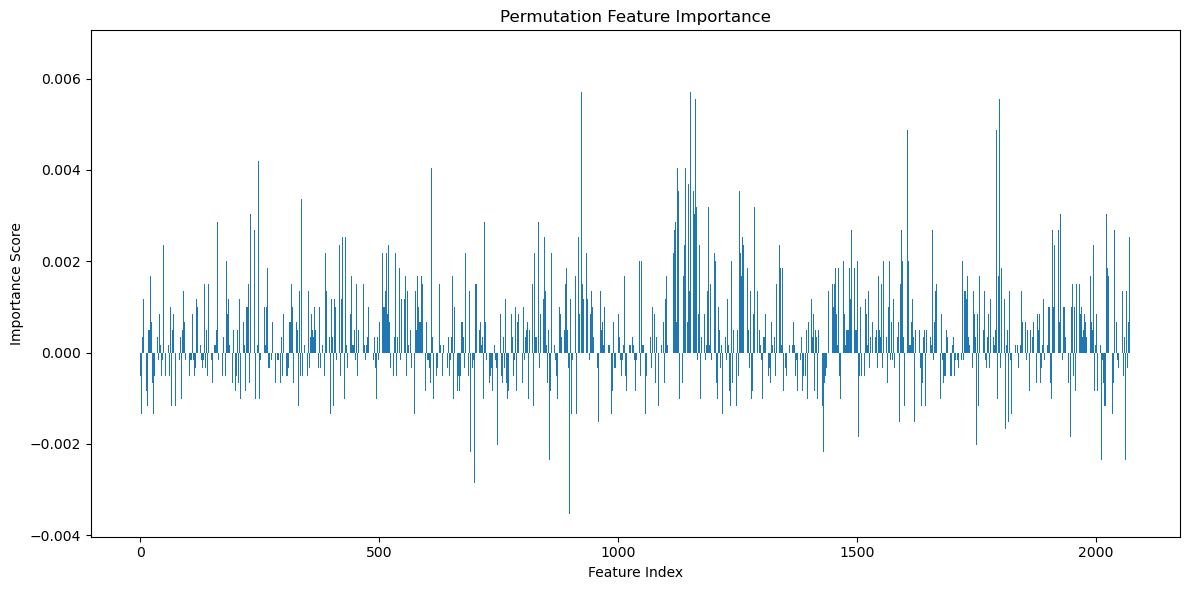

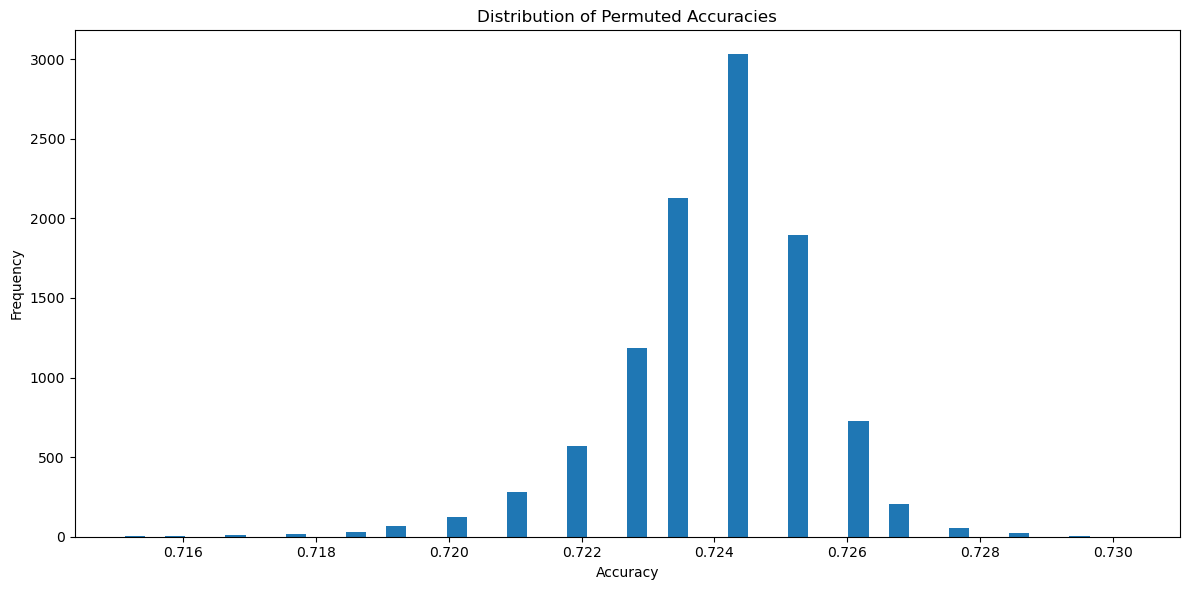

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
input_dim = X_test_transformer.shape[2]
hidden_dim = 128
layer_dim = 1
output_dim = len(np.unique(y_test_transformer))

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load('trained_transformer_lstm_model.pth', map_location=device))
model.to(device)
model.eval()

# Prepare the data
X_test_tensor = torch.FloatTensor(X_test_transformer).to(device)
y_test_tensor = torch.LongTensor(y_test_transformer).to(device)

def compute_accuracy(model, X, y):
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        return accuracy_score(y.cpu().numpy(), predicted.cpu().numpy())

def compute_permutation_importance(model, X_test_tensor, y_test_tensor, n_repeats=5):
    device = X_test_tensor.device
    baseline_accuracy = compute_accuracy(model, X_test_tensor, y_test_tensor)
    print(f"Baseline accuracy: {baseline_accuracy:.4f}")
    
    n_samples, n_timesteps, n_features = X_test_tensor.shape
    importance_scores = np.zeros(n_features)
    permuted_accuracies = np.zeros((n_features, n_repeats))

    for feature in tqdm(range(n_features), desc="Computing permutation importance"):
        for i in range(n_repeats):
            X_permuted = X_test_tensor.clone()
            
            # Permute the feature across all samples and timesteps
            permuted_feature = X_permuted[:, :, feature].reshape(-1)
            permuted_feature = permuted_feature[torch.randperm(len(permuted_feature))]
            X_permuted[:, :, feature] = permuted_feature.reshape(n_samples, n_timesteps)
            
            permuted_accuracy = compute_accuracy(model, X_permuted, y_test_tensor)
            permuted_accuracies[feature, i] = permuted_accuracy
            importance_scores[feature] += baseline_accuracy - permuted_accuracy
        importance_scores[feature] /= n_repeats

    print("\nPermuted accuracies statistics:")
    print(f"Mean: {np.mean(permuted_accuracies):.4f}")
    print(f"Std Dev: {np.std(permuted_accuracies):.4f}")
    print(f"Min: {np.min(permuted_accuracies):.4f}")
    print(f"Max: {np.max(permuted_accuracies):.4f}")

    print("\nImportance scores statistics:")
    print(f"Mean: {np.mean(importance_scores):.6f}")
    print(f"Std Dev: {np.std(importance_scores):.6f}")
    print(f"Min: {np.min(importance_scores):.6f}")
    print(f"Max: {np.max(importance_scores):.6f}")
    print(f"Number of features with zero importance: {np.sum(importance_scores == 0)}")

    return importance_scores, baseline_accuracy, permuted_accuracies

# Usage
importance_scores, baseline_accuracy, permuted_accuracies = compute_permutation_importance(model, X_test_tensor, y_test_tensor)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance_scores)), importance_scores)
plt.title("Permutation Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# Plot distribution of permuted accuracies
plt.figure(figsize=(12, 6))
plt.hist(permuted_accuracies.flatten(), bins=50)
plt.title("Distribution of Permuted Accuracies")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Interpretation

##### Permuted accuracies 
- Mean permuted accuracy roughly the same as baseline, meaning individual features all have small impacts on predictions

##### Permutation feature importance graph 
- Clusters of features with relatively higher importance, as well as clusters with 0 or negative importance. There seems to be potential for stricter encoding, the cluster of features at index 1200 looks promising as a main predictor.

##### Distribution of Permuted Accuracies
- Approximately normal dist around baseline accuracy, means individual feature pertubations don't have much of an effect on model performance

TODO: Take a closer look at features with highest positive and negative importance scores 

#### SHAP analysis (Still working on this)

In [19]:
import torch
import numpy as np
import shap
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
input_dim = X_test_transformer.shape[2]
hidden_dim = 128
layer_dim = 1
output_dim = len(np.unique(y_test_transformer))

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load('trained_transformer_lstm_model.pth', map_location=device))
model.to(device)
model.eval()

# Function to make predictions
def f(X):
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).reshape(-1, 1, input_dim).to(device)
        output = model(X_tensor)
        return output.cpu().numpy()

# Prepare the data
X_test_numpy = X_test_transformer.cpu().numpy().reshape(X_test_transformer.shape[0], -1)

# Create a background dataset (e.g., first 100 samples)
background = X_test_numpy[:100]

# Initialize SHAP explainer
explainer = shap.KernelExplainer(f, background)

# Compute SHAP values (this may take a while)
shap_values = explainer.shap_values(X_test_numpy[:1000])  # Limit to first 1000 samples for speed

# Plot feature importance
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test_numpy[:1000], plot_type="bar")
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Function to map encoding features back to original input space
def map_to_original_space(feature_importance, spike_trains):
    num_features = X_test_transformer.shape[2]
    reshaped_importance = feature_importance.reshape(-1, num_features).mean(axis=0)
    correlations = np.zeros((num_features, spike_trains.shape[1]))
    
    for i in range(num_features):
        for j in range(spike_trains.shape[1]):
            correlations[i, j] = np.corrcoef(X_test_transformer[:, 0, i].cpu().numpy(), spike_trains[:, j])[0, 1]
    
    weighted_correlations = correlations * reshaped_importance[:, np.newaxis]
    original_feature_importance = np.abs(weighted_correlations).sum(axis=0)
    
    return original_feature_importance

# Map back to original space
original_spike_trains = spike_df.drop('frame', axis=1).values
original_feature_importance = map_to_original_space(np.mean(np.abs(shap_values), axis=0), original_spike_trains)

# Plot original feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(original_feature_importance)), original_feature_importance)
plt.title('Original Feature Importance')
plt.xlabel('Neuron Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

print("SHAP analysis and feature importance mapping completed.")

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 